In [3]:
import os
import sys
import string
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import gaussian_laplace, label

## Пути сохранений

In [4]:
PTW = "ptw/"   #Папка с исходниками с камеры
NUM_ARRAY = "num_py_convert"  #Папка с массивами np.array
VIDEO_TERM = "video_term_mp4"  # Папка для сохранения видео термограмм

## Функция получение np.array из .ptw

In [5]:
#НАСТРОЙКИ ПУТЕЙ


#ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ
def mybyte(byte_data):
    return ord(byte_data) if sys.version_info[0] < 3 else byte_data

def myint(byte_data):
    return int.from_bytes(byte_data, byteorder='little')

def mylong(byte_data):
    return int.from_bytes(byte_data, byteorder='little')

def myfloat(byte_data):
    return np.frombuffer(byte_data, dtype=np.float32)[0]

def mydouble(byte_data):
    return np.frombuffer(byte_data, dtype=np.float64)[0]

def myRGB(byte_data):
    return [ord(byte_data[i]) if sys.version_info[0] < 3 else byte_data[i] for i in range(3)]

def terminateStrOnZero(byte_data):
    zero_index = byte_data.find(b'\x00')
    return byte_data[:zero_index] if zero_index != -1 else byte_data

def safe_decode_strip(byte_data):
    s = terminateStrOnZero(byte_data).decode('utf-8', errors='ignore')
    return s.rstrip(s[-1]) if s else ''

class PTWFrameInfo:
    pass

# ЧТЕНИЕ ЗАГОЛОВКА
def readPTWHeader(ptwfilename):
    Header = PTWFrameInfo()
    Header.FileName = ptwfilename
    with open(ptwfilename,'rb') as fid:
        headerinfo = fid.read(16)
        MainHeaderSize = mylong(headerinfo[11:15])
        fid.seek(0)
        headerinfo = fid.read(MainHeaderSize)

    Header.h_Signature = headerinfo[0:3].decode('utf-8') if sys.version_info[0]>2 else headerinfo[0:3]
    Header.h_format = 'cedip' if Header.h_Signature=='CED' else 'agema'
    Header.h_unit = 'dl' if Header.h_format=='cedip' else None
    Header.h_Version = headerinfo[5:10].decode('utf-8', errors='ignore') if sys.version_info[0]>2 else headerinfo[5:10]
    if not Header.h_Version[-1] in string.printable:
        Header.h_Version = Header.h_Version[:-1]

    Header.h_MainHeaderSize = mylong(headerinfo[11:15])
    Header.h_FrameHeaderSize = mylong(headerinfo[15:19])
    Header.h_SizeOfOneFrameAndHeader = mylong(headerinfo[19:23])
    Header.h_SizeOfOneFrame = mylong(headerinfo[23:27])
    Header.h_NumberOfFieldInFile = mylong(headerinfo[27:31])

    # размеры кадра
    Header.h_PixelsPerLine = myint(headerinfo[377:379])
    Header.h_LinesPerField = myint(headerinfo[379:381])
    Header.h_Rows = Header.h_LinesPerField if Header.h_LinesPerField>0 else 128
    Header.h_Cols = Header.h_PixelsPerLine if Header.h_PixelsPerLine>0 else 128
    Header.h_lastframe = Header.h_NumberOfFieldInFile
    Header.h_FrameSize = Header.h_FrameHeaderSize + Header.h_Rows * Header.h_Cols * 2

    # проверка lockin
    with open(ptwfilename,'rb') as fid:
        fid.seek(Header.h_MainHeaderSize + Header.h_FrameHeaderSize)
        firstline = fid.read(Header.h_Cols)
        if len(firstline)>=4 and firstline[1:4]==bytes([0,0,0]):
            Header.h_Lockin=1
            Header.h_Rows -= 1
            print('* LOCKIN')
        else:
            Header.h_Lockin=0
    return Header

# ========== ЧТЕНИЕ КАДРА ==========
def getPTWFrame(header, frameNumber):
    with open(header.FileName,'rb') as fid:
        frame_pos = header.h_MainHeaderSize + (frameNumber-1)*header.h_SizeOfOneFrameAndHeader + header.h_FrameHeaderSize
        fid.seek(frame_pos)
        frame_bytes = fid.read(header.h_SizeOfOneFrame)
        frame_length = len(frame_bytes)//2
        # корректировка rows и cols под реальный размер
        rows = header.h_Rows
        cols = header.h_Cols
        if rows*cols != frame_length:
            cols = 320
            rows = frame_length // cols
        data = np.frombuffer(frame_bytes, dtype=np.uint16).reshape(rows, cols)
    return data, header

# ========== ЧТЕНИЕ ВСЕХ КАДРОВ ==========
def getPTWFrames(header, loadFrames=[]):
    fheaders = []
    npFrames = np.asarray(loadFrames)
    if np.any(npFrames<1) or np.any(npFrames>header.h_lastframe):
        print(f"getPTWFrames Error: frame out of range 1-{header.h_lastframe}")
        return np.asarray([0]), None

    all_frames = []
    for frame in loadFrames:
        data, headerx = getPTWFrame(header, frame)
        all_frames.append(data)
        fheaders.append(headerx)
    return np.array(all_frames), fheaders

## Получение np.array из .ptw

In [6]:
if not os.path.exists(NUM_ARRAY):
    os.makedirs(NUM_ARRAY)

ptws = [f for f in os.listdir(PTW) if f.endswith('.ptw')]
print(f"Найдено {len(ptws)} PTW файлов для обработки")
print(f"Входная папка: {PTW}")
print(f"Выходная папка: {NUM_ARRAY}")

for ptw in tqdm(ptws, total=len(ptws)):
    try:
        header = readPTWHeader(os.path.join(PTW, ptw))
        frames = getPTWFrames(header, range(1, header.h_lastframe+1))[0]
        output_path = os.path.join(NUM_ARRAY, f"therm_{ptw.replace('.ptw','')}.npy")
        np.save(output_path, frames.astype(np.int16))
    except Exception as e:
        print(f"Ошибка при обработке файла {ptw}: {str(e)}")
        continue

Найдено 2 PTW файлов для обработки
Входная папка: ptw/
Выходная папка: num_py_convert


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


## Преобразование np.array в mp4

In [7]:
fps = 25

# Создаем папку для видео, если не существует
if not os.path.exists(VIDEO_TERM):
    os.makedirs(VIDEO_TERM)

# --- Функция сохранения видео ---
def save_video_from_frames(frames, out_path, fps=25):
    """Сохраняет numpy массив кадров в видео с глобальной нормализацией"""
    min_val = np.percentile(frames, 1)
    max_val = np.percentile(frames, 99)
    max_val = max(max_val, min_val + 1e-6)  # защита от деления на ноль

    frames_norm = []
    for f in frames:
        f_clip = np.clip(f, min_val, max_val)
        f_norm = ((f_clip - min_val) / (max_val - min_val) * 255).astype(np.uint8)
        f_color = cv2.applyColorMap(f_norm, cv2.COLORMAP_JET)
        frames_norm.append(f_color)

    h, w, _ = frames_norm[0].shape
    writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
    for f in frames_norm:
        writer.write(f)
    writer.release()
    print(f"Видео сохранено: {out_path}")

# --- Функция просмотра видео в реальном времени ---
def show_video_realtime(frames, fps=25):
    """Показывает термограмму в реальном времени с глобальной нормализацией"""
    delay = int(1000 / fps)
    total = len(frames)
    i = 0
    paused = False

    min_val = np.percentile(frames, 1)
    max_val = np.percentile(frames, 99)
    max_val = max(max_val, min_val + 1e-6)

    cv2.namedWindow("Thermogram", cv2.WINDOW_NORMAL)

    while True:
        try:
            if cv2.getWindowProperty("Thermogram", cv2.WND_PROP_VISIBLE) < 1:
                break
        except cv2.error:
            break

        f = frames[i]
        f_clip = np.clip(f, min_val, max_val)
        f_norm = ((f_clip - min_val) / (max_val - min_val) * 255).astype(np.uint8)
        f_color = cv2.applyColorMap(f_norm, cv2.COLORMAP_JET)

        text = f"Frame {i+1}/{total} {'[PAUSE]' if paused else ''}"
        cv2.putText(f_color, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow("Thermogram", f_color)

        key = cv2.waitKey(0 if paused else delay) & 0xFF

        if key == 27:  # ESC
            break
        elif key == ord(' '):  # пробел — пауза
            paused = not paused
        elif key in [ord('a'), ord('A'), 81]:  # назад
            i = max(0, i - 1)
            paused = True
        elif key in [ord('d'), ord('D'), 83]:  # вперёд
            i = min(total - 1, i + 1)
            paused = True
        elif not paused:
            i = (i + 1) % total

    cv2.destroyAllWindows()

# --- Основной цикл обработки всех .npy файлов ---
npy_files = [f for f in os.listdir(NUM_ARRAY) if f.endswith('.npy')]
print(f"Найдено {len(npy_files)} .npy файлов для конвертации в видео.")

for npy_file in tqdm(npy_files, desc="Конвертация в видео"):
    try:
        frames = np.load(os.path.join(NUM_ARRAY, npy_file))
        print(f"Загружено {len(frames)} кадров из {npy_file}, размер одного кадра: {frames[0].shape}")

        # Сохраняем видео
        video_name = os.path.splitext(npy_file)[0] + ".mp4"
        out_path = os.path.join(VIDEO_TERM, video_name)
        save_video_from_frames(frames, out_path, fps=fps)

        # Просмотр видео
        # show_video_realtime(frames, fps=fps)

    except Exception as e:
        print(f"Ошибка при обработке {npy_file}: {e}")

print("Все видео обработаны!")


Найдено 2 .npy файлов для конвертации в видео.


Конвертация в видео:   0%|          | 0/2 [00:00<?, ?it/s]

Загружено 1500 кадров из therm_8.npy, размер одного кадра: (128, 320)


Конвертация в видео:  50%|█████     | 1/2 [00:03<00:03,  3.45s/it]

Видео сохранено: video_term_mp4/therm_8.mp4
Загружено 3000 кадров из therm_43.npy, размер одного кадра: (128, 320)


Конвертация в видео: 100%|██████████| 2/2 [00:11<00:00,  5.55s/it]

Видео сохранено: video_term_mp4/therm_43.mp4
Все видео обработаны!


## Функция запуска

In [8]:
def play_videos_from_folder(folder_path, fps=25):
    """
    Проигрывает все видео в указанной папке по одному.
    Управление:
        ESC - выйти
        ПРОБЕЛ - пауза/воспроизведение
        A/LEFT - назад (кадр)
        D/RIGHT - вперед (кадр)
        N - следующее видео
        Закрытие окна крестиком - выход из функции
    """
    video_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.mp4')])
    if not video_files:
        print("В папке нет видео.")
        return

    for vid_file in video_files:
        video_path = os.path.join(folder_path, vid_file)
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Не удалось открыть видео: {vid_file}")
            continue

        print(f"Воспроизведение: {vid_file}")
        paused = False
        frame_index = 0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        cv2.namedWindow("Video Player", cv2.WINDOW_NORMAL)

        while True:
            # Проверка, закрыто ли окно крестиком
            try:
                if cv2.getWindowProperty("Video Player", cv2.WND_PROP_VISIBLE) < 1:
                    cap.release()
                    cv2.destroyAllWindows()
                    return
            except cv2.error:
                cap.release()
                cv2.destroyAllWindows()
                return

            if not paused:
                ret, frame = cap.read()
                if not ret:
                    break
                frame_index += 1
            else:
                # Если пауза, остаёмся на текущем кадре
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                ret, frame = cap.read()
                if not ret:
                    break

            if frame is None:
                break

            text = f"{vid_file}  Frame {frame_index}/{total_frames} {'[PAUSE]' if paused else ''}"
            cv2.putText(frame, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.imshow("Video Player", frame)

            key = cv2.waitKey(int(1000/fps)) & 0xFF

            if key == 27:  # ESC
                cap.release()
                cv2.destroyAllWindows()
                return
            elif key == ord(' '):  # пробел — пауза/воспроизведение
                paused = not paused
            elif key in [ord('a'), ord('A'), 81]:  # назад
                frame_index = max(0, frame_index - 1)
                paused = True
            elif key in [ord('d'), ord('D'), 83]:  # вперед
                frame_index = min(total_frames - 1, frame_index + 1)
                paused = True
            elif key in [ord('n'), ord('N')]:  # следующее видео
                break

        cap.release()

    cv2.destroyAllWindows()
    print("Все видео воспроизведены.")


## Запуск видео

In [9]:
# play_videos_from_folder("video_term_mp4", fps=25)


# Вытаскивем признаки из видео (на самом деле из последовательности массивов)

In [10]:
def min_loc_LoG(image: np.ndarray, sigma: float = 2.0):
    """
    Находит минимум (яркую точку) на изображении через фильтр Лапласа-Гаусса (LoG).
    Используется для поиска горячих точек (всплесков температуры).
    """
    log = gaussian_laplace(image, sigma=sigma)
    min_val = np.min(log)
    min_loc = np.unravel_index(np.argmin(log), log.shape)
    return min_loc, min_val

In [11]:
def detect_spatters(frame: np.ndarray, spat_thr_val: float = 95, min_area: int = 3):
    """
    Детектирует брызги (spatters) — локальные горячие точки.
    spat_thr_val — порог в процентах (0–100): чем ниже, тем чувствительнее.
    Возвращает список центров и радиусов для кружков, 
    исключая самый большой брызг.
    """
    # Нормализация и вычисление порога
    norm = cv2.normalize(frame.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
    thresh_val = np.percentile(norm, spat_thr_val)

    # Бинаризация и морфологическая обработка
    mask = (norm > thresh_val).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    # Метки связных областей
    labeled, n = label(mask)

    spatters = []
    for k in range(1, n + 1):
        ys, xs = np.where(labeled == k)
        if len(xs) >= min_area:
            cx, cy = int(np.mean(xs)), int(np.mean(ys))
            radii = np.sqrt((xs - cx)**2 + (ys - cy)**2)
            radius = int(np.max(radii)) + 2  # чуть больше радиуса области
            spatters.append((cx, cy, radius))

    # Удаляем самый большой брызг по радиусу
    if spatters:
        max_idx = np.argmax([r for _, _, r in spatters])
        spatters.pop(max_idx)

    return spatters


In [12]:
def detect_welding_zone(frame: np.ndarray, blur_ksize: int = 15, zone_thr_val: float = 70):
    """
    Определяет основную зону сварки — крупную яркую область.
    zone_thr_val — порог в процентах (0–100): чем меньше, тем больше зона.
    Возвращает бинарную маску (1 — зона сварки).
    """
    # Размываем для подавления мелких всплесков
    blurred = cv2.GaussianBlur(frame.astype(np.float32), (blur_ksize, blur_ksize), 0)
    norm = cv2.normalize(blurred, None, 0, 1, cv2.NORM_MINMAX)
    thresh_val = np.percentile(norm, zone_thr_val)

    # Бинаризация
    _, mask = cv2.threshold(norm, thresh_val, 1, cv2.THRESH_BINARY)
    mask = mask.astype(np.uint8)

    # Находим компоненты и оставляем только самую большую
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = (labels == largest).astype(np.uint8)
    return mask

## Пример использования

Найдено всплесков: 7


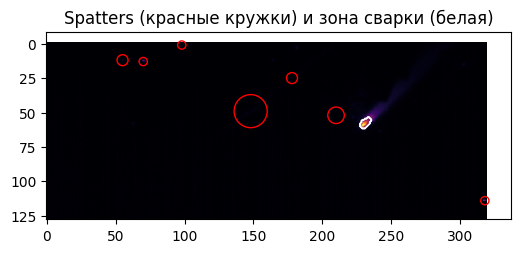

In [13]:
# === Пример использования ===
frames = np.load("num_py_convert/therm_8.npy")
frame = frames[520]  # примерный кадр

spatters = detect_spatters(frame, spat_thr_val=95, min_area=2)
weld_zone = detect_welding_zone(frame, zone_thr_val=99.9)

print("Найдено всплесков:", len(spatters))

# Визуализация
plt.figure(figsize=(6, 6))
plt.imshow(frame, cmap='inferno')

ax = plt.gca()
# Рисуем красные кружки вокруг каждого брызга
for cx, cy, r in spatters:
    circle = patches.Circle((cx, cy), r, edgecolor='red', facecolor='none', linewidth=1)
    ax.add_patch(circle)

# Контур зоны сварки
plt.contour(weld_zone, colors='white', linewidths=0.5)
plt.title("Spatters (красные кружки) и зона сварки (белая)")
plt.show()

In [14]:
def frame_to_rgb_inferno(frame):
    """
    Преобразует 2D термограмму в RGB с cmap='inferno'
    """
    norm_frame = frame.astype(np.float32)
    norm_frame -= norm_frame.min()
    norm_frame /= (norm_frame.max() + 1e-6)
    norm_frame_uint8 = (norm_frame*255).astype(np.uint8)
    cmap = plt.get_cmap('inferno')
    colored = cmap(norm_frame_uint8)[:, :, :3]  # убираем альфа-канал
    rgb_frame = (colored*255).astype(np.uint8)
    return cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)  # OpenCV использует BGR

def show_video_cv2(frames, spat_thr_val=95, zone_thr_val=99.9, fps=10):
    total = len(frames)
    i = 0
    paused = False
    delay = int(1000/fps)

    cv2.namedWindow("Thermogram", cv2.WINDOW_NORMAL)

    while True:
        # проверка, закрыто ли окно
        try:
            if cv2.getWindowProperty("Thermogram", cv2.WND_PROP_VISIBLE) < 1:
                break
        except cv2.error:
            break

        frame = frames[i]
        rgb_frame = frame_to_rgb_inferno(frame)

        # брызги
        spatters = detect_spatters(frame, spat_thr_val=spat_thr_val, min_area=2)
        for cx, cy, r in spatters:
            cv2.circle(rgb_frame, (cx, cy), r, (0, 0, 255), 1)

        # зона сварки
        weld_zone = detect_welding_zone(frame, zone_thr_val=zone_thr_val)
        contours, _ = cv2.findContours(weld_zone.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(rgb_frame, contours, -1, (255, 255, 255), 1)

        # текст
        text = f"Frame {i+1}/{total} {'[PAUSE]' if paused else ''}"
        cv2.putText(rgb_frame, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        cv2.imshow("Thermogram", rgb_frame)

        key = cv2.waitKey(0 if paused else delay) & 0xFF
        if key == 27:  # ESC
            break
        elif key == ord(' '):
            paused = not paused
        elif key in [ord('a'), ord('A'), 81]:  # назад
            i = max(0, i-1)
            paused = True
        elif key in [ord('d'), ord('D'), 83]:  # вперед
            i = min(total-1, i+1)
            paused = True
        elif not paused:
            i = (i+1) % total

    cv2.destroyAllWindows()
    return  # завершает выполнение функции и ячейки

In [24]:

# === Использование ===
frames = np.load("num_py_convert/therm_43.npy")
show_video_cv2(frames, spat_thr_val=95, zone_thr_val=99.9)